# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(140, 180, '$+ 10 \%$', fontsize=12)
        plt.text(150, 120, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [7]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 301, step=3),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.05))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                  loss="mean_squared_error",
                  #metrics=['accuracy']
                  metrics = ['mean_squared_error']
                 )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [8]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [10]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir_Patience',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

Trial 2074 Complete [00h 01m 39s]
val_loss: 4085.574951171875

Best val_loss So Far: 78.50843048095703
Total elapsed time: 02h 43m 52s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
27/27 [==============================] - 0s 740us/step - loss: 227.9209 - mean_squared_error: 227.9209
Epoch 2/1000
27/27 [==============================] - 0s 741us/step - loss: 219.0604 - mean_squared_error: 219.0604
Epoch 3/1000
27/27 [==============================] - 0s 740us/step - loss: 278.2473 - mean_squared_error: 278.2473
Epoch 4/1000
27/27 [==============================] - 0s 740us/step - loss: 254.7060 - mean_squared_error: 254.7060
Epoch 5/1000
27/27 [==============================] - 0s 723us/step - loss: 203.6648 - mean_squared_error: 203.6648
Epoch 6/1000
27/27 [==============================] - 0s 740us/step - loss: 264.3456 - mean_squared_error: 264.3456
Epoch 7/1000
27/27 [==============================] - 0s 703us/step - loss: 199.0217 - mean_squared_error: 199.0217
Epoch 8/1000
27

27/27 [==============================] - 0s 740us/step - loss: 157.0225 - mean_squared_error: 157.0225
Epoch 70/1000
27/27 [==============================] - 0s 708us/step - loss: 226.5093 - mean_squared_error: 226.5093
Epoch 71/1000
27/27 [==============================] - 0s 703us/step - loss: 195.4984 - mean_squared_error: 195.4984
Epoch 72/1000
27/27 [==============================] - 0s 666us/step - loss: 177.4535 - mean_squared_error: 177.4535
Epoch 73/1000
27/27 [==============================] - 0s 699us/step - loss: 197.9969 - mean_squared_error: 197.9969
Epoch 74/1000
27/27 [==============================] - 0s 705us/step - loss: 133.4248 - mean_squared_error: 133.4248
Epoch 75/1000
27/27 [==============================] - 0s 703us/step - loss: 219.5890 - mean_squared_error: 219.5890
Epoch 76/1000
27/27 [==============================] - 0s 703us/step - loss: 151.9869 - mean_squared_error: 151.9869
Epoch 77/1000
27/27 [==============================] - 0s 745us/step - loss: 1

27/27 [==============================] - 0s 703us/step - loss: 177.9257 - mean_squared_error: 177.9257
Epoch 139/1000
27/27 [==============================] - 0s 703us/step - loss: 202.3162 - mean_squared_error: 202.3162
Epoch 140/1000
27/27 [==============================] - 0s 703us/step - loss: 218.8388 - mean_squared_error: 218.8388
Epoch 141/1000
27/27 [==============================] - 0s 711us/step - loss: 267.6150 - mean_squared_error: 267.6150
Epoch 142/1000
27/27 [==============================] - 0s 703us/step - loss: 157.8589 - mean_squared_error: 157.8589
Epoch 143/1000
27/27 [==============================] - 0s 703us/step - loss: 209.5604 - mean_squared_error: 209.5604
Epoch 144/1000
27/27 [==============================] - 0s 666us/step - loss: 239.6147 - mean_squared_error: 239.6147
Epoch 145/1000
27/27 [==============================] - 0s 693us/step - loss: 188.6236 - mean_squared_error: 188.6236
Epoch 146/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 666us/step - loss: 181.8671 - mean_squared_error: 181.8671
Epoch 208/1000
27/27 [==============================] - 0s 703us/step - loss: 157.0390 - mean_squared_error: 157.0390
Epoch 209/1000
27/27 [==============================] - 0s 703us/step - loss: 245.4392 - mean_squared_error: 245.4392
Epoch 210/1000
27/27 [==============================] - 0s 701us/step - loss: 185.8533 - mean_squared_error: 185.8533
Epoch 211/1000
27/27 [==============================] - 0s 685us/step - loss: 180.4497 - mean_squared_error: 180.4497
Epoch 212/1000
27/27 [==============================] - 0s 731us/step - loss: 183.1750 - mean_squared_error: 183.1750
Epoch 213/1000
27/27 [==============================] - 0s 666us/step - loss: 281.5724 - mean_squared_error: 281.5724
Epoch 214/1000
27/27 [==============================] - 0s 703us/step - loss: 232.5697 - mean_squared_error: 232.5697
Epoch 215/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 703us/step - loss: 193.3124 - mean_squared_error: 193.3124
Epoch 277/1000
27/27 [==============================] - 0s 703us/step - loss: 175.0417 - mean_squared_error: 175.0417
Epoch 278/1000
27/27 [==============================] - 0s 703us/step - loss: 223.0492 - mean_squared_error: 223.0492
Epoch 279/1000
27/27 [==============================] - 0s 703us/step - loss: 247.5213 - mean_squared_error: 247.5213
Epoch 280/1000
27/27 [==============================] - 0s 666us/step - loss: 209.1116 - mean_squared_error: 209.1116
Epoch 281/1000
27/27 [==============================] - 0s 687us/step - loss: 209.0056 - mean_squared_error: 209.0056
Epoch 282/1000
27/27 [==============================] - 0s 703us/step - loss: 197.9938 - mean_squared_error: 197.9938
Epoch 283/1000
27/27 [==============================] - 0s 740us/step - loss: 179.5171 - mean_squared_error: 179.5171
Epoch 284/1000
27/27 [==============================] - 0s 695us/step -

27/27 [==============================] - 0s 735us/step - loss: 249.0022 - mean_squared_error: 249.0022
Epoch 346/1000
27/27 [==============================] - 0s 703us/step - loss: 146.4990 - mean_squared_error: 146.4990
Epoch 347/1000
27/27 [==============================] - 0s 702us/step - loss: 249.2484 - mean_squared_error: 249.2484
Epoch 348/1000
27/27 [==============================] - 0s 703us/step - loss: 180.3988 - mean_squared_error: 180.3988
Epoch 349/1000
27/27 [==============================] - 0s 730us/step - loss: 181.5916 - mean_squared_error: 181.5916
Epoch 350/1000
27/27 [==============================] - 0s 703us/step - loss: 198.5922 - mean_squared_error: 198.5922
Epoch 351/1000
27/27 [==============================] - 0s 703us/step - loss: 203.0016 - mean_squared_error: 203.0016
Epoch 352/1000
27/27 [==============================] - 0s 703us/step - loss: 171.0736 - mean_squared_error: 171.0736
Epoch 353/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 703us/step - loss: 142.7799 - mean_squared_error: 142.7799
Epoch 415/1000
27/27 [==============================] - 0s 703us/step - loss: 279.0769 - mean_squared_error: 279.0769
Epoch 416/1000
27/27 [==============================] - 0s 666us/step - loss: 124.8191 - mean_squared_error: 124.8191
Epoch 417/1000
27/27 [==============================] - 0s 703us/step - loss: 146.3279 - mean_squared_error: 146.3279
Epoch 418/1000
27/27 [==============================] - 0s 703us/step - loss: 221.9218 - mean_squared_error: 221.9218
Epoch 419/1000
27/27 [==============================] - 0s 703us/step - loss: 183.6295 - mean_squared_error: 183.6295
Epoch 420/1000
27/27 [==============================] - 0s 703us/step - loss: 206.2754 - mean_squared_error: 206.2754
Epoch 421/1000
27/27 [==============================] - 0s 703us/step - loss: 184.0594 - mean_squared_error: 184.0594
Epoch 422/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 703us/step - loss: 186.6639 - mean_squared_error: 186.6639
Epoch 484/1000
27/27 [==============================] - 0s 703us/step - loss: 226.4331 - mean_squared_error: 226.4331
Epoch 485/1000
27/27 [==============================] - 0s 715us/step - loss: 152.0730 - mean_squared_error: 152.0730
Epoch 486/1000
27/27 [==============================] - 0s 703us/step - loss: 208.8194 - mean_squared_error: 208.8194
Epoch 487/1000
27/27 [==============================] - 0s 707us/step - loss: 188.8700 - mean_squared_error: 188.8700
Epoch 488/1000
27/27 [==============================] - 0s 666us/step - loss: 201.4238 - mean_squared_error: 201.4238
Epoch 489/1000
27/27 [==============================] - 0s 703us/step - loss: 140.4963 - mean_squared_error: 140.4963
Epoch 490/1000
27/27 [==============================] - 0s 666us/step - loss: 175.3470 - mean_squared_error: 175.3470
Epoch 491/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 703us/step - loss: 171.9773 - mean_squared_error: 171.9773
Epoch 553/1000
27/27 [==============================] - 0s 703us/step - loss: 196.4757 - mean_squared_error: 196.4757
Epoch 554/1000
27/27 [==============================] - 0s 703us/step - loss: 182.6221 - mean_squared_error: 182.6221
Epoch 555/1000
27/27 [==============================] - 0s 740us/step - loss: 198.3360 - mean_squared_error: 198.3360
Epoch 556/1000
27/27 [==============================] - 0s 725us/step - loss: 125.7536 - mean_squared_error: 125.7536
Epoch 557/1000
27/27 [==============================] - 0s 703us/step - loss: 156.0758 - mean_squared_error: 156.0758
Epoch 558/1000
27/27 [==============================] - 0s 703us/step - loss: 197.5753 - mean_squared_error: 197.5753
Epoch 559/1000
27/27 [==============================] - 0s 703us/step - loss: 152.5576 - mean_squared_error: 152.5576
Epoch 560/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 703us/step - loss: 128.0975 - mean_squared_error: 128.0975
Epoch 622/1000
27/27 [==============================] - 0s 703us/step - loss: 198.7526 - mean_squared_error: 198.7526
Epoch 623/1000
27/27 [==============================] - 0s 740us/step - loss: 281.6530 - mean_squared_error: 281.6530
Epoch 624/1000
27/27 [==============================] - 0s 703us/step - loss: 172.6523 - mean_squared_error: 172.6523
Epoch 625/1000
27/27 [==============================] - 0s 703us/step - loss: 203.6426 - mean_squared_error: 203.6426
Epoch 626/1000
27/27 [==============================] - 0s 675us/step - loss: 241.4568 - mean_squared_error: 241.4568
Epoch 627/1000
27/27 [==============================] - 0s 777us/step - loss: 170.7438 - mean_squared_error: 170.7438
Epoch 628/1000
27/27 [==============================] - 0s 740us/step - loss: 140.2369 - mean_squared_error: 140.2369
Epoch 629/1000
27/27 [==============================] - 0s 740us/step -

27/27 [==============================] - 0s 703us/step - loss: 200.5953 - mean_squared_error: 200.5953
Epoch 691/1000
27/27 [==============================] - 0s 723us/step - loss: 296.1704 - mean_squared_error: 296.1704
Epoch 692/1000
27/27 [==============================] - 0s 703us/step - loss: 216.0204 - mean_squared_error: 216.0204
Epoch 693/1000
27/27 [==============================] - 0s 666us/step - loss: 167.7088 - mean_squared_error: 167.7088
Epoch 694/1000
27/27 [==============================] - 0s 703us/step - loss: 186.8678 - mean_squared_error: 186.8678
Epoch 695/1000
27/27 [==============================] - 0s 703us/step - loss: 170.8834 - mean_squared_error: 170.8834
Epoch 696/1000
27/27 [==============================] - 0s 703us/step - loss: 179.8937 - mean_squared_error: 179.8937
Epoch 697/1000
27/27 [==============================] - 0s 703us/step - loss: 168.2724 - mean_squared_error: 168.2724
Epoch 698/1000
27/27 [==============================] - 0s 704us/step -

27/27 [==============================] - 0s 720us/step - loss: 189.1716 - mean_squared_error: 189.1716
Epoch 760/1000
27/27 [==============================] - 0s 703us/step - loss: 204.7270 - mean_squared_error: 204.7270
Epoch 761/1000
27/27 [==============================] - 0s 703us/step - loss: 177.2185 - mean_squared_error: 177.2185
Epoch 762/1000
27/27 [==============================] - 0s 703us/step - loss: 165.8905 - mean_squared_error: 165.8905
Epoch 763/1000
27/27 [==============================] - 0s 703us/step - loss: 148.8393 - mean_squared_error: 148.8393
Epoch 764/1000
27/27 [==============================] - 0s 703us/step - loss: 166.1898 - mean_squared_error: 166.1898
Epoch 765/1000
27/27 [==============================] - 0s 666us/step - loss: 203.9593 - mean_squared_error: 203.9593
Epoch 766/1000
27/27 [==============================] - 0s 703us/step - loss: 165.1850 - mean_squared_error: 165.1850
Epoch 767/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 666us/step - loss: 143.5369 - mean_squared_error: 143.5369
Epoch 829/1000
27/27 [==============================] - 0s 703us/step - loss: 191.5357 - mean_squared_error: 191.5357
Epoch 830/1000
27/27 [==============================] - 0s 703us/step - loss: 168.7739 - mean_squared_error: 168.7739
Epoch 831/1000
27/27 [==============================] - 0s 703us/step - loss: 203.5386 - mean_squared_error: 203.5386
Epoch 832/1000
27/27 [==============================] - 0s 703us/step - loss: 214.0942 - mean_squared_error: 214.0942
Epoch 833/1000
27/27 [==============================] - 0s 703us/step - loss: 163.4254 - mean_squared_error: 163.4254
Epoch 834/1000
27/27 [==============================] - 0s 703us/step - loss: 162.9793 - mean_squared_error: 162.9793
Epoch 835/1000
27/27 [==============================] - 0s 666us/step - loss: 169.2103 - mean_squared_error: 169.2103
Epoch 836/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 666us/step - loss: 218.1405 - mean_squared_error: 218.1405
Epoch 898/1000
27/27 [==============================] - 0s 703us/step - loss: 193.2806 - mean_squared_error: 193.2806
Epoch 899/1000
27/27 [==============================] - 0s 740us/step - loss: 188.4919 - mean_squared_error: 188.4919
Epoch 900/1000
27/27 [==============================] - 0s 703us/step - loss: 168.9381 - mean_squared_error: 168.9381
Epoch 901/1000
27/27 [==============================] - 0s 713us/step - loss: 189.4496 - mean_squared_error: 189.4496
Epoch 902/1000
27/27 [==============================] - 0s 703us/step - loss: 156.2554 - mean_squared_error: 156.2554
Epoch 903/1000
27/27 [==============================] - 0s 666us/step - loss: 161.1302 - mean_squared_error: 161.1302
Epoch 904/1000
27/27 [==============================] - 0s 703us/step - loss: 192.9819 - mean_squared_error: 192.9819
Epoch 905/1000
27/27 [==============================] - 0s 703us/step -

27/27 [==============================] - 0s 687us/step - loss: 174.4876 - mean_squared_error: 174.4876
Epoch 967/1000
27/27 [==============================] - 0s 703us/step - loss: 190.7566 - mean_squared_error: 190.7566
Epoch 968/1000
27/27 [==============================] - 0s 703us/step - loss: 176.1608 - mean_squared_error: 176.1608
Epoch 969/1000
27/27 [==============================] - 0s 703us/step - loss: 153.6715 - mean_squared_error: 153.6715
Epoch 970/1000
27/27 [==============================] - 0s 700us/step - loss: 184.4003 - mean_squared_error: 184.4003
Epoch 971/1000
27/27 [==============================] - 0s 703us/step - loss: 224.5761 - mean_squared_error: 224.5761
Epoch 972/1000
27/27 [==============================] - 0s 714us/step - loss: 176.7723 - mean_squared_error: 176.7723
Epoch 973/1000
27/27 [==============================] - 0s 695us/step - loss: 146.0178 - mean_squared_error: 146.0178
Epoch 974/1000
27/27 [==============================] - 0s 684us/step -

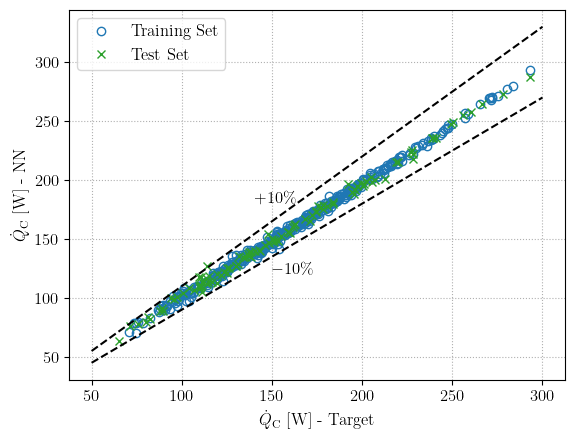

In [11]:
NeuNet(X_train,y_train,1000,'Qc')

Trial 725 Complete [00h 01m 47s]
val_loss: 43.90321350097656

Best val_loss So Far: 0.36543580889701843
Total elapsed time: 00h 55m 37s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
21/21 [==============================] - 0s 871us/step - loss: 5.6876 - mean_squared_error: 5.6876
Epoch 2/500
21/21 [==============================] - 0s 810us/step - loss: 3.9929 - mean_squared_error: 3.9929
Epoch 3/500
21/21 [==============================] - 0s 761us/step - loss: 6.4834 - mean_squared_error: 6.4834
Epoch 4/500
21/21 [==============================] - 0s 761us/step - loss: 6.0919 - mean_squared_error: 6.0919
Epoch 5/500
21/21 [==============================] - 0s 762us/step - loss: 7.3442 - mean_squared_error: 7.3442
Epoch 6/500
21/21 [==============================] - 0s 798us/step - loss: 4.4364 - mean_squared_error: 4.4364
Epoch 7/500
21/21 [==============================] - 0s 761us/step - loss: 7.2291 - mean_squared_error: 7.2291
Epoch 8/500
21/21 [==============================

21/21 [==============================] - 0s 761us/step - loss: 5.3300 - mean_squared_error: 5.3300
Epoch 73/500
21/21 [==============================] - 0s 761us/step - loss: 5.4460 - mean_squared_error: 5.4460
Epoch 74/500
21/21 [==============================] - 0s 761us/step - loss: 4.9285 - mean_squared_error: 4.9285
Epoch 75/500
21/21 [==============================] - 0s 714us/step - loss: 6.6446 - mean_squared_error: 6.6446
Epoch 76/500
21/21 [==============================] - 0s 714us/step - loss: 7.0044 - mean_squared_error: 7.0044
Epoch 77/500
21/21 [==============================] - 0s 738us/step - loss: 6.7855 - mean_squared_error: 6.7855
Epoch 78/500
21/21 [==============================] - 0s 762us/step - loss: 4.0558 - mean_squared_error: 4.0558
Epoch 79/500
21/21 [==============================] - 0s 761us/step - loss: 5.7985 - mean_squared_error: 5.7985
Epoch 80/500
21/21 [==============================] - 0s 762us/step - loss: 6.8007 - mean_squared_error: 6.8007
Epoch

21/21 [==============================] - 0s 761us/step - loss: 5.8592 - mean_squared_error: 5.8592
Epoch 145/500
21/21 [==============================] - 0s 714us/step - loss: 3.6816 - mean_squared_error: 3.6816
Epoch 146/500
21/21 [==============================] - 0s 761us/step - loss: 4.7426 - mean_squared_error: 4.7425
Epoch 147/500
21/21 [==============================] - 0s 904us/step - loss: 7.1109 - mean_squared_error: 7.1109
Epoch 148/500
21/21 [==============================] - 0s 809us/step - loss: 3.6893 - mean_squared_error: 3.6893
Epoch 149/500
21/21 [==============================] - 0s 762us/step - loss: 6.1465 - mean_squared_error: 6.1465
Epoch 150/500
21/21 [==============================] - 0s 738us/step - loss: 4.0992 - mean_squared_error: 4.0992
Epoch 151/500
21/21 [==============================] - 0s 714us/step - loss: 8.5253 - mean_squared_error: 8.5253
Epoch 152/500
21/21 [==============================] - 0s 762us/step - loss: 5.2654 - mean_squared_error: 5.26

21/21 [==============================] - 0s 761us/step - loss: 6.4866 - mean_squared_error: 6.4866
Epoch 217/500
21/21 [==============================] - 0s 724us/step - loss: 4.5981 - mean_squared_error: 4.5981
Epoch 218/500
21/21 [==============================] - 0s 714us/step - loss: 6.4181 - mean_squared_error: 6.4181
Epoch 219/500
21/21 [==============================] - 0s 762us/step - loss: 6.3136 - mean_squared_error: 6.3136
Epoch 220/500
21/21 [==============================] - 0s 788us/step - loss: 5.9958 - mean_squared_error: 5.9958
Epoch 221/500
21/21 [==============================] - 0s 786us/step - loss: 5.8533 - mean_squared_error: 5.8533
Epoch 222/500
21/21 [==============================] - 0s 761us/step - loss: 4.9256 - mean_squared_error: 4.9256
Epoch 223/500
21/21 [==============================] - 0s 714us/step - loss: 9.7441 - mean_squared_error: 9.7441
Epoch 224/500
21/21 [==============================] - 0s 761us/step - loss: 6.5282 - mean_squared_error: 6.52

21/21 [==============================] - 0s 762us/step - loss: 4.0365 - mean_squared_error: 4.0365
Epoch 289/500
21/21 [==============================] - 0s 729us/step - loss: 5.2852 - mean_squared_error: 5.2852
Epoch 290/500
21/21 [==============================] - 0s 762us/step - loss: 4.7131 - mean_squared_error: 4.7131
Epoch 291/500
21/21 [==============================] - 0s 761us/step - loss: 5.5550 - mean_squared_error: 5.5550
Epoch 292/500
21/21 [==============================] - 0s 714us/step - loss: 5.6816 - mean_squared_error: 5.6816
Epoch 293/500
21/21 [==============================] - 0s 762us/step - loss: 6.0239 - mean_squared_error: 6.0239
Epoch 294/500
21/21 [==============================] - 0s 761us/step - loss: 5.6205 - mean_squared_error: 5.6205
Epoch 295/500
21/21 [==============================] - 0s 761us/step - loss: 4.8431 - mean_squared_error: 4.8431
Epoch 296/500
21/21 [==============================] - 0s 761us/step - loss: 5.7872 - mean_squared_error: 5.78

21/21 [==============================] - 0s 746us/step - loss: 5.6444 - mean_squared_error: 5.6444
Epoch 361/500
21/21 [==============================] - 0s 761us/step - loss: 4.6380 - mean_squared_error: 4.6380
Epoch 362/500
21/21 [==============================] - 0s 747us/step - loss: 4.9158 - mean_squared_error: 4.9158
Epoch 363/500
21/21 [==============================] - 0s 827us/step - loss: 5.2281 - mean_squared_error: 5.2281
Epoch 364/500
21/21 [==============================] - 0s 796us/step - loss: 5.7188 - mean_squared_error: 5.7188
Epoch 365/500
21/21 [==============================] - 0s 761us/step - loss: 5.7564 - mean_squared_error: 5.7564
Epoch 366/500
21/21 [==============================] - 0s 809us/step - loss: 6.0549 - mean_squared_error: 6.0549
Epoch 367/500
21/21 [==============================] - 0s 802us/step - loss: 6.0201 - mean_squared_error: 6.0201
Epoch 368/500
21/21 [==============================] - 0s 809us/step - loss: 5.0228 - mean_squared_error: 5.02

21/21 [==============================] - 0s 762us/step - loss: 4.1715 - mean_squared_error: 4.1715
Epoch 433/500
21/21 [==============================] - 0s 761us/step - loss: 4.1441 - mean_squared_error: 4.1441
Epoch 434/500
21/21 [==============================] - 0s 714us/step - loss: 5.9463 - mean_squared_error: 5.9463
Epoch 435/500
21/21 [==============================] - 0s 762us/step - loss: 5.1294 - mean_squared_error: 5.1294
Epoch 436/500
21/21 [==============================] - 0s 809us/step - loss: 4.8149 - mean_squared_error: 4.8149
Epoch 437/500
21/21 [==============================] - 0s 761us/step - loss: 7.4437 - mean_squared_error: 7.4437
Epoch 438/500
21/21 [==============================] - 0s 743us/step - loss: 5.7368 - mean_squared_error: 5.7368
Epoch 439/500
21/21 [==============================] - 0s 800us/step - loss: 4.8385 - mean_squared_error: 4.8385
Epoch 440/500
21/21 [==============================] - 0s 761us/step - loss: 6.4392 - mean_squared_error: 6.43

The coefficient of determination for Wm Training Set using Neural Networks is 0.9977551030901888
The coefficient of determination for Wm Test Set using Neural Networks is 0.9982094172360145


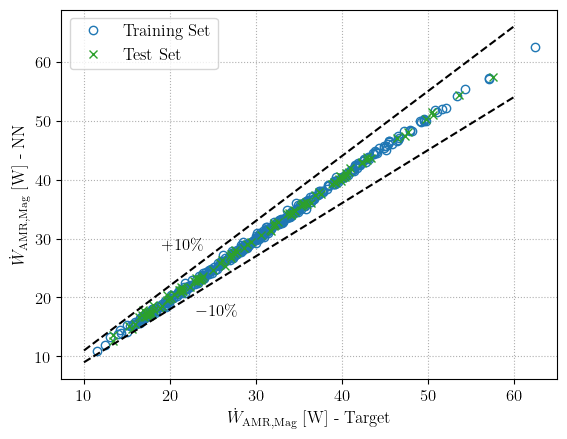

In [12]:
NeuNet(X_train,y_train,500,'Wm')